In [6]:
from SPARQLWrapper import SPARQLWrapper, JSON
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline



# Helpers functions

In [7]:
YAGO_ENDPOINT = "https://yago-knowledge.org/sparql/query"

def get_sparql_dataframe(query):
    """
    Helper function to convert SPARQL results into a Pandas data frame.
    """
    sparql = SPARQLWrapper(YAGO_ENDPOINT)
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    result = sparql.query()

    processed_results = json.load(result.response)
    cols = processed_results['head']['vars']

    out = []
    for row in processed_results['results']['bindings']:
        item = []
        for c in cols:
            item.append(row.get(c, {}).get('value'))
        out.append(item)

    return pd.DataFrame(out, columns=cols)

def transform_dates(x):
    if(len(x) > 4): 
        return int(x[:4]) 
    else: 
        return int(x)
    
def transform_to_month(x):
    if(len(x) > 4): 
        return int(x[5:7]) 
    
def calc_live_len(df):
    df['born_year'] = df['born'].apply(transform_dates)
    df['deth_year'] = df['die'].apply(transform_dates)
    df['live_len'] = df['deth_year'] - df['born_year']
    stats = df.groupby(pd.cut(df["born_year"], np.arange(0, 2100, 100))).mean()['live_len'].to_frame()
    stats['count'] = df.groupby(pd.cut(df["born_year"], np.arange(0, 2100, 100))).count()['born'].to_frame()
    stats['std'] = df.groupby(pd.cut(df["born_year"], np.arange(0, 2100, 100))).std()['live_len'].to_frame()
    return stats

def create_query(query):
    return """PREFIX schema: <http://schema.org/>
            PREFIX sc: <http://purl.org/science/owl/sciencecommons/>
            PREFIX ya: <http://blogs.yandex.ru/schema/foaf/>
            PREFIX yago: <http://yago-knowledge.org/resource/>
            PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
            PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#> {}""".format(query)


## First query

I spotted lack of gender data in YAGO 4

In [8]:
df_all = get_sparql_dataframe(create_query("""
SELECT *WHERE {
?obj schema:birthDate ?born.
?obj schema:deathDate ?die .
}
"""))
df_male = get_sparql_dataframe(create_query("""
SELECT *WHERE {
?obj schema:birthDate ?born.
?obj schema:deathDate ?die .
?obj schema:gender ?gender .
} 
"""))
# yago have lack of gender informations
df_male

In [18]:
df_male

obj        born  \
30323    http://yago-knowledge.org/resource/Catharina_M...        1687   
33049    http://yago-knowledge.org/resource/Ulrika_Eleo...        1688   
111237     http://yago-knowledge.org/resource/Harry_Stokes        1799   
117909   http://yago-knowledge.org/resource/Sarah_Roset...  1843-01-16   
155873    http://yago-knowledge.org/resource/Andreas_Bruce  1808-12-28   
...                                                    ...         ...   
1181414     http://yago-knowledge.org/resource/Léon_Caurla  1926-09-04   
1181732  http://yago-knowledge.org/resource/Alexander_J...        1960   
1194337  http://yago-knowledge.org/resource/Bobbi_Jean_...        1964   
1194406  http://yago-knowledge.org/resource/Effy_Beth_Q...        1989   
1194753    http://yago-knowledge.org/resource/Lucy_Meadows        1981   

                die                                          gender  \
30323    1721-11-08    http://yago-knowledge.org/resource/Trans_man   
33049    1733-02-16    http://yago-knowledge.org/resource/Trans_man   
111237   1859-10-15    http://yago-knowledge.org/resource/Trans_man   
117909   1864-06-19    http://yago-knowledge.org/resource/Trans_man   
155873   1885-01-27    http://yago-knowledge.org/resource/Trans_man   
...             ...                                             ...   
1181414        2002    http://yago-knowledge.org/resource/Trans_man   
1181732        2002    http://yago-knowledge.org/resource/Trans_man   
1194337        2014  http://yago-knowledge.org/resource/Trans_woman   
1194406        2014  http://yago-knowledge.org/resource/Trans_woman   
1194753        2013  http://yago-knowledge.org/resource/Trans_woman   

         born_year  deth_year  live_len  
30323         1687       1721        34  
33049         1688       1733        45  
111237        1799       1859        60  
117909        1843       1864        21  
155873        1808       1885        77  
...            ...        ...       ...  
1181414       1926       2002        76  
1181732       1960       2002        42  
1194337       1964       2014        50  
1194406       1989       2014        25  
1194753       1981       2013        32  

[133 rows x 7 columns]

In [9]:
stats_all = calc_live_len(df_all)
stats_male = calc_live_len(df_male)

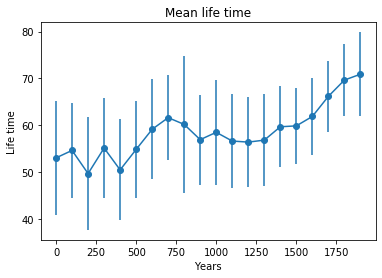

In [10]:
fig, ax = plt.subplots()


ax.errorbar(np.arange(0,2000,100), stats_all['live_len'],
            yerr=stats_all['std']/2,
            fmt='-o')

# ax.errorbar(np.arange(0,2100,100), stats_male['live_len'],
#             yerr=stats_male['std'],
#             fmt='-o')



ax.set_xlabel('Years')
ax.set_ylabel('Life time')
ax.set_title('Mean life time')


plt.show()

# Birth months

In [11]:
birth_month = get_sparql_dataframe(create_query("""
SELECT *WHERE {
?obj schema:birthDate ?born.
?obj schema:deathDate ?die .
}
"""))
birth_month

obj        born  \
0               http://yago-knowledge.org/resource/Cao_Cao  0155-03-18   
1        http://yago-knowledge.org/resource/Lucius_Calp...        0038   
2        http://yago-knowledge.org/resource/Philip_of_A...        0040   
3        http://yago-knowledge.org/resource/Tryphon,_Re...        0232   
4              http://yago-knowledge.org/resource/Aurelian  0214-09-09   
...                                                    ...         ...   
1375589  http://yago-knowledge.org/resource/Lillian_Cla...  1940-02-02   
1375590  http://yago-knowledge.org/resource/David_Sayer...  1936-09-19   
1375591  http://yago-knowledge.org/resource/George_Will...        1935   
1375592  http://yago-knowledge.org/resource/Peter_Riege...  1953-04-12   
1375593  http://yago-knowledge.org/resource/Yavuz_Selim...        1961   

                die  
0        0220-03-15  
1        0069-01-15  
2        0103-05-12  
3        0250-02-02  
4        0275-09-25  
...             ...  
1375589     2016-12  
1375590     2017-01  
1375591     2017-01  
1375592     2017-01  
1375593     2016-11  

[1375594 rows x 3 columns]

In [12]:
birth_month['birth_month'] = birth_month['born'].apply(transform_to_month)
birth_month['death_month'] = birth_month['die'].apply(transform_to_month)

In [13]:
x = birth_month.groupby('birth_month').count()

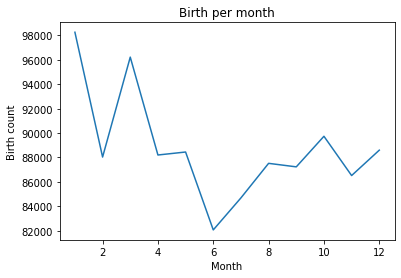

In [14]:
fig, ax = plt.subplots()


ax.plot(np.arange(1,13,1), x['obj'],)

ax.set_xlabel('Month')
ax.set_ylabel('Birth count')
ax.set_title('Birth per month')


plt.show()

# Perfect age for first child

In [15]:
birth_month = get_sparql_dataframe(create_query("""
SELECT *WHERE {
?person schema:birthDate ?born.
?child schema:parent ?person .
?child schema:birthDate ?child_born.
} 
"""))
birth_month['born'] = birth_month['born'].apply(transform_dates)
birth_month['child_born'] = birth_month['child_born'].apply(transform_dates)
first_child = birth_month.groupby("person").min()
first_child['age'] = first_child['child_born'] - first_child['born']
first_child['last'] = birth_month.groupby("person").max()['child_born']
first_child['last_age'] = first_child['last'] - first_child['born']
stats_child = first_child.groupby(pd.cut(first_child["born"], np.arange(0, 2100, 100))).mean()['age'].to_frame()
stats_child['std'] = first_child.groupby(pd.cut(first_child["born"], np.arange(0, 2100, 100))).std()['age'].to_frame()
stats_child['last_mean'] = first_child.groupby(pd.cut(first_child["born"], np.arange(0, 2100, 100))).mean()['last_age'].to_frame()
stats_child['last_std'] = first_child.groupby(pd.cut(first_child["born"], np.arange(0, 2100, 100))).std()['last_age'].to_frame()
stats_child

age        std  last_mean   last_std
born                                                    
(0, 100]      24.947368  11.616433  26.157895  12.280351
(100, 200]    31.555556  13.146307  34.416667  13.620101
(200, 300]    27.060606  18.683113  29.939394  19.121224
(300, 400]    29.038462  14.553433  31.711538  15.126054
(400, 500]    29.047059  11.780640  31.364706  11.542723
(500, 600]    28.951613  14.638180  32.903226  15.829739
(600, 700]    28.333333  15.292601  31.155556  15.573806
(700, 800]    29.264151  14.173582  33.547170  14.104781
(800, 900]    30.878261  12.594309  33.904348  15.302777
(900, 1000]   32.818182  45.751422  36.085561  45.966364
(1000, 1100]  30.784661  25.019949  33.979351  25.114345
(1100, 1200]  29.764706  11.817732  33.493213  12.664382
(1200, 1300]  28.593407  13.006402  32.001832  13.545370
(1300, 1400]  29.263773  12.289725  32.742905  12.958927
(1400, 1500]  31.790805  19.142189  34.366667  19.187946
(1500, 1600]  32.094163  11.991262  35.487005  12.487749
(1600, 1700]  32.386386  12.212056  35.821592  13.021820
(1700, 1800]  33.278735  10.139523  36.071238  10.574721
(1800, 1900]  33.063343   9.090342  35.028986   9.396738
(1900, 2000]  30.066262   8.412320  31.274520   8.763704

In [16]:
fig, ax = plt.subplots()


ax.errorbar(np.arange(0,2000,100), stats_child['age'],
            yerr = stats_child['std']/2,
            fmt='-o')

ax.errorbar(np.arange(0,2000,100), stats_child['last_mean'],
            yerr = stats_child['last_std']/2,
            fmt='-o')

ax.set_xlabel('x-axis')
ax.set_ylabel('y-axis')
ax.set_title('Line plot with error bars')


plt.show()

In [17]:
first_child

born  \
person                                                     
http://yago-knowledge.org/resource/'Abd_al-Ahad...  1859   
http://yago-knowledge.org/resource/'Adud_al-Dawla    936   
http://yago-knowledge.org/resource/(Philippe)_V...  1746   
http://yago-knowledge.org/resource/A.-M._Julien     1903   
http://yago-knowledge.org/resource/A._A._Ermich...  1936   
...                                                  ...   
http://yago-knowledge.org/resource/Аleksandr_Ru...  1847   
http://yago-knowledge.org/resource/Дубянецкі_Мі...  1927   
http://yago-knowledge.org/resource/Ḣ._Ă._Ălii̐e...  1907   
http://yago-knowledge.org/resource/Ḥayim_Meʼir_...  1887   
http://yago-knowledge.org/resource/松岡操_Q11530013    1832   

                                                                                                child  \
person                                                                                                  
http://yago-knowledge.org/resource/'Abd_al-Ahad...  http://yago-knowledge.org/resource/Mohammed_Al...   
http://yago-knowledge.org/resource/'Adud_al-Dawla    http://yago-knowledge.org/resource/Baha_al-Dawla   
http://yago-knowledge.org/resource/(Philippe)_V...  http://yago-knowledge.org/resource/Philippe_An...   
http://yago-knowledge.org/resource/A.-M._Julien     http://yago-knowledge.org/resource/François_Ma...   
http://yago-knowledge.org/resource/A._A._Ermich...  http://yago-knowledge.org/resource/Kirill_Yerm...   
...                                                                                               ...   
http://yago-knowledge.org/resource/Аleksandr_Ru...  http://yago-knowledge.org/resource/Rusov_Myhay...   
http://yago-knowledge.org/resource/Дубянецкі_Мі...  http://yago-knowledge.org/resource/Halina_Duby...   
http://yago-knowledge.org/resource/Ḣ._Ă._Ălii̐e...  http://yago-knowledge.org/resource/Rasim_Aliye...   
http://yago-knowledge.org/resource/Ḥayim_Meʼir_...  http://yago-knowledge.org/resource/Mordechai_H...   
http://yago-knowledge.org/resource/松岡操_Q11530013    http://yago-knowledge.org/resource/Eikyū_Matsu...   

                                                    child_born  age  last  \
person                                                                      
http://yago-knowledge.org/resource/'Abd_al-Ahad...        1880   21  1880   
http://yago-knowledge.org/resource/'Adud_al-Dawla          963   27   971   
http://yago-knowledge.org/resource/(Philippe)_V...        1776   30  1776   
http://yago-knowledge.org/resource/A.-M._Julien           1925   22  1925   
http://yago-knowledge.org/resource/A._A._Ermich...        1974   38  1974   
...                                                        ...  ...   ...   
http://yago-knowledge.org/resource/Аleksandr_Ru...        1876   29  1895   
http://yago-knowledge.org/resource/Дубянецкі_Мі...        1962   35  1964   
http://yago-knowledge.org/resource/Ḣ._Ă._Ălii̐e...        1934   27  1934   
http://yago-knowledge.org/resource/Ḥayim_Meʼir_...        1916   29  1922   
http://yago-knowledge.org/resource/松岡操_Q11530013          1860   28  1881   

                                                    last_age  
person                                                        
http://yago-knowledge.org/resource/'Abd_al-Ahad...        21  
http://yago-knowledge.org/resource/'Adud_al-Dawla         35  
http://yago-knowledge.org/resource/(Philippe)_V...        30  
http://yago-knowledge.org/resource/A.-M._Julien           22  
http://yago-knowledge.org/resource/A._A._Ermich...        38  
...                                                      ...  
http://yago-knowledge.org/resource/Аleksandr_Ru...        48  
http://yago-knowledge.org/resource/Дубянецкі_Мі...        37  
http://yago-knowledge.org/resource/Ḣ._Ă._Ălii̐e...        27  
http://yago-knowledge.org/resource/Ḥayim_Meʼir_...        35  
http://yago-knowledge.org/resource/松岡操_Q11530013          49  

[72008 rows x 6 columns]